## Worksheet 2:  Run the Classification

This uses the data that was saved when the first worksheet was run and creates a classification.

The next cell can be used to set the number of university types, and the number and names of non-university organizations that should be used for the classification.

After computing the classification, the aggregated adjacency matrix is calculated, displayed and saved.  One version of the aggregate adjacency matrix is saved as a tex file called 'nice_adjacency_table.tex' in the current_estimates_and_files directory.  This way the table can be imported into the body of the paper when it is written.

The other version is saved in a serialized format in the file 'placement_rates.jld'.  This can be loaded directly into the next worksheet so that the classification doesn't have to be re-computed each time you work on the value estimation file.

The wordcloud versions of the top and second tiers aren't saved.  You'll have to add code if you want them.

In [1]:
using HTTP, JSON, PrettyTables, JLD, DotEnv, WordCloud, Random, Dates
DEBUG_LEVEL = 1
#if you want a list of universities in each tier set this to true
show_tier_members = false
include("functions/type_allocation_flexible.jl")
public_sector = ("Public Sector", Set())
private_sector = ("Private Sector", Set())
other_groups = ("Other Groups", Set())
postdocs = ("Postdocs", Set())
lecturers = ("Lecturers", Set())
other_academic = ("Other Academic", Set())
unmatched = ("Unmatched", Set())
# choose the number of academic types
NUMBER_OF_TYPES = 5
# choose which of the sets declared above your want to include in the classification
sinks_to_include = (public_sector, private_sector,postdocs,lecturers,unmatched, other_groups);
# teaching universities are discovered by finding institutions that hire but  never graduate, so they are added automatically
NUMBER_OF_SINKS = length(sinks_to_include)+1
numtotal = NUMBER_OF_TYPES + NUMBER_OF_SINKS
cfg = DotEnv.config("../.env")
files_path = cfg["files_path"]
# check mysql database econjobmarket research table algorithm_runs for information about the date when the 
# data was assembled this is the primary key id of this entry
algorithm_run_id = 5

5

In [2]:
# designed to fetch data from disk
# currently run mike_assemble_data.ipynb to refresh data from the api source
to_from_by_year_api = SBM_flexible.fetch_data(files_path*"to_from_by_year.json");

In [3]:
# the number of placements im ocean and crow - currently a proxy for failed trades
n = 0
m = 0
for (key,value) in  to_from_by_year_api
    for (k,v) in value
        if v["to_institution_id"] == 754
           n += 1
        end
    end
end
println(n)

2434


In [4]:
academic, academic_to, academic_builder, rough_sink_builder, institution_mapping, reverse_mapping = SBM_flexible.get_builders(to_from_by_year_api);

In [5]:
#save(files_path*"/academic_builder.jld", "academic_builder", academic_builder)

In [6]:
# sink of teaching universities that do not graduate PhDs
# this must be constructed using academic placements, not pre-defined sink placements

teaching_universities = Set() 
for dept_name in academic_to
    if !(dept_name in academic)
        # the department hired an assistant professor but never graduated anyone
        push!(teaching_universities, dept_name)
    end
end
println(length(teaching_universities))


for outcome in rough_sink_builder
    if outcome["disappeared"] == 1 #untrackable applicants
        #push!(unmatched[2], (string(outcome["to_name"], " ($(unmatched[1]))"), outcome))
        push!(unmatched[2], (outcome["to_name"], outcome))
    elseif outcome["recruiter_type"] == 5 # government institution
        #push!(public_sector[2], (string(outcome["to_name"], " ($(public_sector[1]))"), outcome))
        push!(public_sector[2], (outcome["to_name"], outcome))
    elseif outcome["recruiter_type"] in [6, 7] # private sector: for and not for profit
        #push!(private_sector[2], (string(outcome["to_name"], " ($(private_sector[1]))"), outcome))
        push!(private_sector[2], (outcome["to_name"], outcome))
    elseif outcome["recruiter_type"] == 8 # international organizations, think tanks, assorted
        #push!(other_groups[2], (string(outcome["to_name"], " ($(other_groups[1]))"), outcome))
        push!(other_groups[2], (outcome["to_name"], outcome))

    # some other examples
    # every example here must also have a corresponding sink Set() above, 
    #     and an entry in sinks_to_include below
   
    elseif outcome["postype"] == 6
        # postdocs that are not in the above (i.e. academic; not public, private, or other)
        # requires reconfiguration of the to_from_by_year loading code
        #push!(postdocs[2], (string(outcome["to_name"], " ($(postdocs[1]))"), outcome))
        push!(postdocs[2], (outcome["to_name"], outcome))
    elseif outcome["postype"] in [5, 7]
        # lecturers that are not in the above
        # requires reconfiguration of the to_from_by_year loading code
        #push!(lecturers[2], (string(outcome["to_name"], " ($(lecturers[1]))"), outcome))
        push!(lecturers[2], (outcome["to_name"], outcome))
    else
        # everything else including terminal academic positions
        # this sink can only be constructed as an "else" statement
        #push!(other_academic[2], (string(outcome["to_name"], " ($(other_academic[1]))"), outcome))
        push!(other_academic[2], (outcome["to_name"], outcome))
    
    end
end

# sort to ensure consistent ordering
academic_list = sort(collect(academic))
teaching_list = sort(collect(teaching_universities))
# to be consistent with the original estimation, we only include these additional sinks:


sink_builder, sinks, sink_labels = SBM_flexible.build_sinks(sinks_to_include, teaching_list)

institutions = vcat(academic_list, sinks...)
println("$(length(academic_list)) academic departments, $(length(institutions)) total departments")

642
Including the following sinks:
 Public Sector
 Private Sector
 Postdocs
 Lecturers
 Unmatched
 Other Groups
 Teaching Universities
Total 7 sinks
1114 academic departments, 3185 total departments


In [7]:
filtered_data = copy(academic_builder)
m = 0
for (x,t) in sink_builder
   push!(filtered_data, t)
end


#println(length(academic_builder) + length(sink_builder))
println(length(filtered_data))
#sink_labels

17472


In [8]:
save(files_path*"/filtered_data.jld", "filtered_data", filtered_data)

In [9]:
out = SBM_flexible.get_adjacency(academic_list, institutions, academic_builder, sink_builder);

Total 17472 Placements (found 17472 by sequence counting, 17472 by matrix sum)


In [10]:
using Optim, Random
Random.seed!(0)

TaskLocalRNG()

In [11]:
function β(K, likelihoods, λ, numtotal_test, n)
    return likelihoods[K] - λ * ((K * numtotal_test) / 2) * n * log(n)
end

function w(β_vec)
    return β_vec ./ sum(β_vec)
end

function objective_to_minimize(λ_vec, range_K, likelihoods, numsink, n)
    λ = λ_vec[1] # just 1-D
    if λ < 0 
        return Inf 
    end
    w_vec = w([β(K, likelihoods, λ, K + numsink, n) for K in range_K])
    return sum(w_vec .* log.(w_vec))
end

objective_to_minimize (generic function with 1 method)

In [12]:
Random.seed!(0) # for reproducibility
@time est_obj, est_alloc = SBM_flexible.doit(out, length(academic_list), [length(s) for s in sinks], NUMBER_OF_TYPES, numtotal, 500 * (NUMBER_OF_TYPES-2) + 1000)

994.742356 seconds (383.57 k allocations: 20.027 MiB, 0.01% compilation time)


(39379.755236135374, Int32[2, 4, 4, 3, 3, 3, 3, 3, 3, 2  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [13]:
placement_rates, counts, sorted_allocation, full_likelihood = 
SBM_flexible.get_allocation(est_alloc, out, NUMBER_OF_TYPES, numtotal, institutions);

debug bas line 295 
Int32[1194 43 4 172 338; 270 409 33 451 506; 0 28 163 53 42; 1073 146 34 986 1381; 950 91 10 314 853; 568 57 23 285 545; 777 55 26 230 441; 86 56 27 135 130; 34 41 48 69 59; 367 413 341 752 599; 210 32 9 83 165; 240 159 69 420 377]
Int32[400 6680 10440 3600 1160; 6680 111556 174348 60120 19372; 10440 174348 272484 93960 30276; 3600 60120 93960 32400 10440; 1160 19372 30276 10440 3364; 3040 50768 79344 27360 8816; 4540 75818 118494 40860 13166; 11960 199732 312156 107640 34684; 8260 137942 215586 74340 23954; 20 334 522 180 58; 760 12692 19836 6840 2204; 12840 214428 335124 115560 37236]


In [14]:
#save(files_path*"/est_mat.jld",
 #   "est_mat", est_mat)
placement_rates

12×5 Matrix{Int32}:
 1194   338  172   43    4
  950   853  314   91   10
 1073  1381  986  146   34
  270   506  451  409   33
    0    42   53   28  163
  568   545  285   57   23
  777   441  230   55   26
   86   130  135   56   27
   34    59   69   41   48
  367   599  752  413  341
  210   165   83   32    9
  240   377  420  159   69

In [15]:

save(files_path*"/sinks.jld", "sinks", sinks)

In [30]:
unmatched_index = 0
counter = zeros(Int64,NUMBER_OF_TYPES+NUMBER_OF_SINKS);
for sorted_type in 1:NUMBER_OF_TYPES+NUMBER_OF_SINKS
    #counter = 0
    inst_hold = []
    println("TYPE $sorted_type:")
    for (i, sbm_type) in enumerate(sorted_allocation)
        if sbm_type == sorted_type
            push!(inst_hold, institutions[i])
            counter[sorted_type] += 1
        end
    end
    if show_tier_members
        for inst in sort(inst_hold)
        println("  ", inst)
        end
    end
    println("Total Institutions: ",counter[sorted_type])
    if counter[sorted_type] == 1
        unmatched_index = sorted_type
    end
    println()
end
println( "Unmatched Index ", unmatched_index)

TYPE 1:
Total Institutions: 20

TYPE 2:
Total Institutions: 58

TYPE 3:
Total Institutions: 180

TYPE 4:
Total Institutions: 334

TYPE 5:
Total Institutions: 522

TYPE 6:
Total Institutions: 152

TYPE 7:
Total Institutions: 227

TYPE 8:
Total Institutions: 598

TYPE 9:
Total Institutions: 413

TYPE 10:
Total Institutions: 1

TYPE 11:
Total Institutions: 38

TYPE 12:
Total Institutions: 642

Unmatched Index 10


In [33]:
# define row titles for the adjacency matrix, include institution counts
names = []

for i in 1:NUMBER_OF_TYPES + NUMBER_OF_SINKS
    if i <= NUMBER_OF_TYPES
        push!(names,string("TYPE ", i, " (", counter[i]," insts)"))
    else
        push!(names, string(sink_labels[i - NUMBER_OF_TYPES], " (", counter[i]," insts)"))
    end
#counter\
end


In [34]:
classification_properties = Dict("algorithm_run_id" => algorithm_run_id, 
    "institution_counts" => counter, "num_years" => length(to_from_by_year_api),
    "row_labels" => names,
    "data_loaded" => Dates.unix2datetime(mtime(files_path*"to_from_by_year.json")),
    "unmatched_index" => unmatched_index, "number_of_academic_types" => NUMBER_OF_TYPES)
save(files_path*"classification_properties.jld", "classification_properties", classification_properties)

In [18]:
# define row titles for the adjacency matrix, include institution counts
names = []

for i in 1:NUMBER_OF_TYPES + NUMBER_OF_SINKS
    if i <= NUMBER_OF_TYPES
        push!(names,string("TYPE ", i, " (", counter[i]," insts)"))
    else
        push!(names, string(sink_labels[i - NUMBER_OF_TYPES], " (", counter[i]," insts)"))
    end
#counter\
end
SBM_flexible.nice_adjacency_table(placement_rates, names)

┌───────────────────────────────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│                                   │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Tier 5 │ Row Totals │
├───────────────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│                 TYPE 1 (20 insts) │   1194 │    338 │    172 │     43 │      4 │       1751 │
│                 TYPE 2 (58 insts) │    950 │    853 │    314 │     91 │     10 │       2218 │
│                TYPE 3 (180 insts) │   1073 │   1381 │    986 │    146 │     34 │       3620 │
│                TYPE 4 (334 insts) │    270 │    506 │    451 │    409 │     33 │       1669 │
│                TYPE 5 (522 insts) │      0 │     42 │     53 │     28 │    163 │        286 │
│         Public Sector (152 insts) │    568 │    545 │    285 │     57 │     23 │       1478 │
│        Private Sector (227 insts) │    777 │    441 │    230 │     55 │     26 │       1529 │
│              Postdocs (598 insts) │   

In [28]:
length(unmatched[2])

50

In [20]:
type_dictionary = []
for (i, alloc) in enumerate(sorted_allocation)
    if alloc in 1:NUMBER_OF_TYPES
        inst_id = reverse_mapping[institutions[i]]
        push!(type_dictionary, Dict("name" => institutions[i], "institution_id" => inst_id, "type" => alloc))
    end
end

In [21]:
open(files_path*"id_to_type_api.json", "w") do f
    write(f, JSON.json(type_dictionary))
end;

In [22]:
SBM_flexible.nice_adjacency_table(placement_rates,names, files_path*"nice_adjacency_table.tex")

In [23]:
#save the adjacency matrix to pass on to the value estimates file
save(files_path*"/placement_rates.jld", "placement_rates", placement_rates)
save(files_path*"row_names.jld", "names", names)


Total words: 21.0. Unique words: 21. After filtration: 16.
The top 16 words are kept. 
color scheme: :Hokusai3, random size: 5
angles = 0
shape(ellipse, 221, 221, color=(0.955, 0.987, 0.929), padding=19)
fonts = "DejaVu Sans Regular"
mask size: 259×259, volume: 195² (49²/word)
set fontsize ∈ [8.0, 259]
set density = 0.5
⋯scale=54.43315855248527, density=0.6306177819965195	↑
⋯scale=48.46915309674691, density=0.49778516057585825	↓
fontsize ∈ [9.586371744415866, 23.870252659752307]


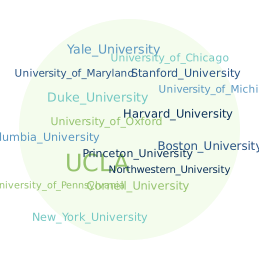

In [24]:
words = ""
weights = []

for inst in type_dictionary
    if inst["type"] == 1
        temp_word = replace(inst["name"], " " => "_")
        words = words * replace(temp_word,"," => "") * " "
        push!(weights, length(inst["name"]))
    end
end

wc = wordcloud(words)


In [25]:
generate!(wc)
paint(wc, ".estimates/type1.svg")
#words

▸1. Set spacing = 2; scale = 48.574599818311704
Completed after 49 epochs.


Total words: 61.0. Unique words: 61. After filtration: 53.
The top 53 words are kept. 
color scheme: :tableau_red_blue_brown, random size: 1, shuffled
angles = [30, -30]
backgroundcolor = :maskcolor
shape(box, 400, 400, cornerradius=27, color=(0.997, 0.992, 0.984), padding=39)
fonts = "DejaVu Serif Light"
mask size: 478×478, volume: 399² (55²/word)
set fontsize ∈ [8.0, 478]
set density = 0.5
⋯scale=61.289600213573124, density=0.6361138806569894	↑
⋯scale=54.338088208417, density=0.5053479582098548	↑
fontsize ∈ [10.02664866765906, 22.91847063121265]


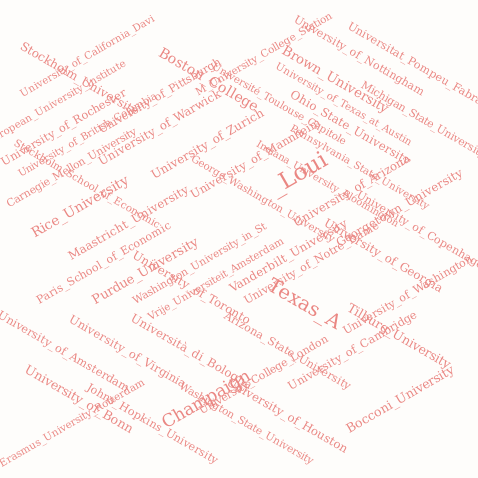

In [26]:
using WordCloud, Random
words = ""
weights = []

for inst in type_dictionary
    if inst["type"] == 2
        temp_word = replace(inst["name"], " " => "_")
        words = words * replace(temp_word,"," => "") * " "
        push!(weights, length(inst["name"]))
    end
end

wc = wordcloud(words)
